<a href="https://colab.research.google.com/github/ChGol/BankTraining/blob/master/bikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Competition Name: Bike Sharing Demand

https://www.kaggle.com/c/bike-sharing-demand/data

Dataset Download:

In [12]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
! mkdir ~/.kaggle


Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
     |████████████████████████████████| 61kB 2.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=2a6bf14b953860ab0de3b6ae9dca9c2aa6a846b9f577c41dbcd3f60eefa639f3
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
Kaggle API 1.5.6
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
from google.colab import files
files.upload()

In [25]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c bike-sharing-demand
!unzip bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv    
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                
  inflating: train.csv               


# Dataset inspection
https://www.kaggle.com/c/bike-sharing-demand/data

- datetime - hourly date + timestamp
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather -
1. Clear, Few clouds, Partly cloudy, Partly cloudy
2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [60]:
# Dataset inspection
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv('train.csv', parse_dates=['datetime'])
test = pd.read_csv('test.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [36]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [38]:
train.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2471,2011-06-10 21:00:00,2,0,1,1,31.16,36.365,66,8.9981,55,163,218
8474,2012-07-14 11:00:00,3,0,0,2,29.52,34.090,70,7.0015,143,296,439
452,2011-02-01 22:00:00,1,0,1,2,9.02,12.880,87,6.0032,2,34,36
6561,2012-03-10 15:00:00,1,0,0,1,13.94,18.180,25,0.0000,132,274,406
9239,2012-09-08 08:00:00,3,0,0,1,28.70,33.335,79,22.0028,33,197,230
2247,2011-06-01 13:00:00,2,0,1,1,36.90,40.910,37,12.9980,29,125,154
4477,2011-10-18 14:00:00,4,0,1,2,25.42,31.060,41,11.0014,32,137,169
7758,2012-06-03 15:00:00,2,0,0,1,28.70,31.820,34,0.0000,236,408,644
5843,2012-01-18 16:00:00,1,0,1,1,11.48,11.365,30,35.0008,13,163,176
10739,2012-12-13 21:00:00,4,0,1,1,11.48,15.910,48,0.0000,13,200,213


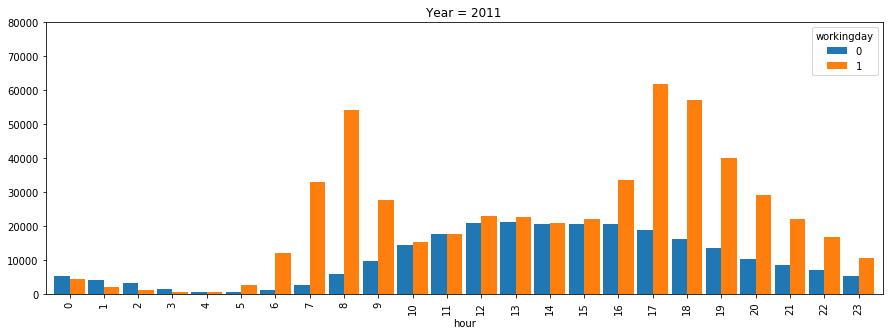

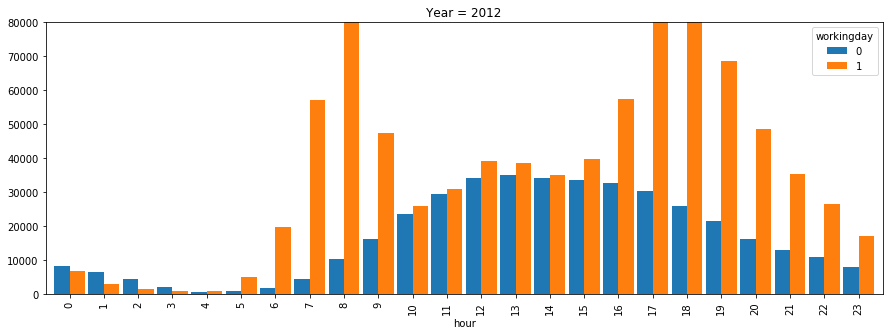

In [40]:
def plot_by_hour(data, year=None, agg='sum'):
    plot_data = data.copy()
    if year:
        plot_data = plot_data[plot_data.datetime.dt.year == year]
    plot_data.loc[:, 'hour'] = plot_data.datetime.dt.hour
    by_hour = plot_data.groupby(['hour', 'workingday'])['count'].agg(agg).unstack()
    return by_hour.plot(kind='bar', ylim=(0, 80000), figsize=(15, 5), width=0.9, title="Year = {0}".format(year))


plot_by_hour(train, year=2011)
plot_by_hour(train, year=2012)

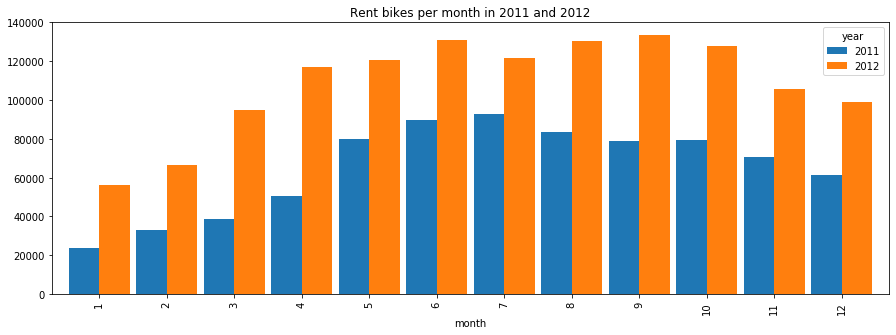

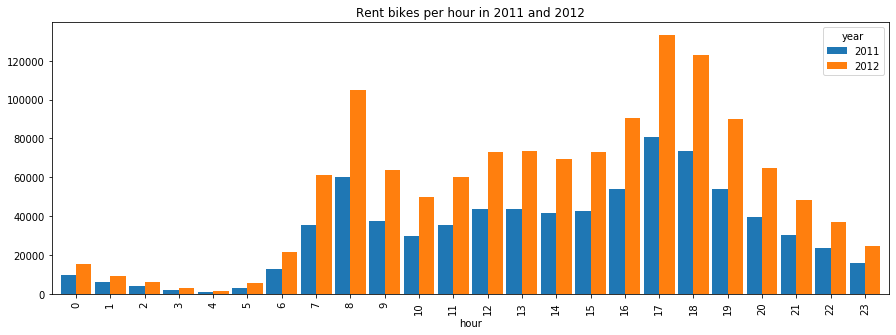

In [43]:
def plot_by_year(data, agg_attr, title):
    plot_data = data.copy()
    plot_data['year'] = data.datetime.dt.year
    plot_data['month'] = data.datetime.dt.month
    plot_data['hour'] = data.datetime.dt.hour
    by_year = plot_data.groupby([agg_attr, 'year'])['count'].agg('sum').unstack()
    return by_year.plot(kind='bar', figsize=(15, 5), width=0.9, title=title)


plot_by_year(train, 'month', "Rent bikes per month in 2011 and 2012")
plot_by_year(train, 'hour', "Rent bikes per hour in 2011 and 2012")

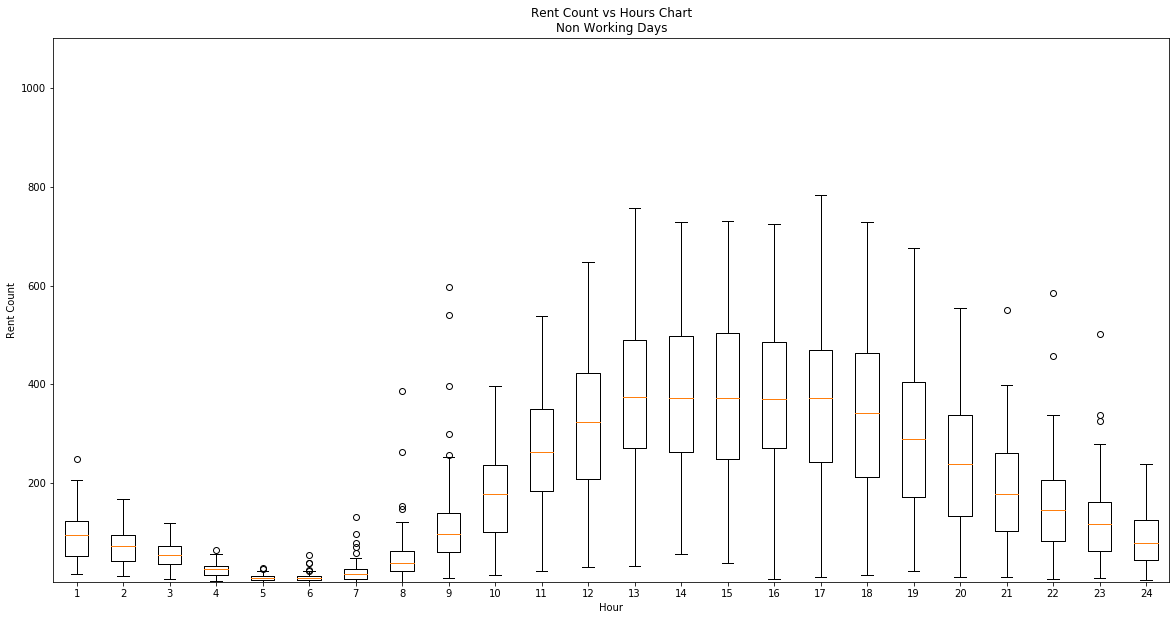

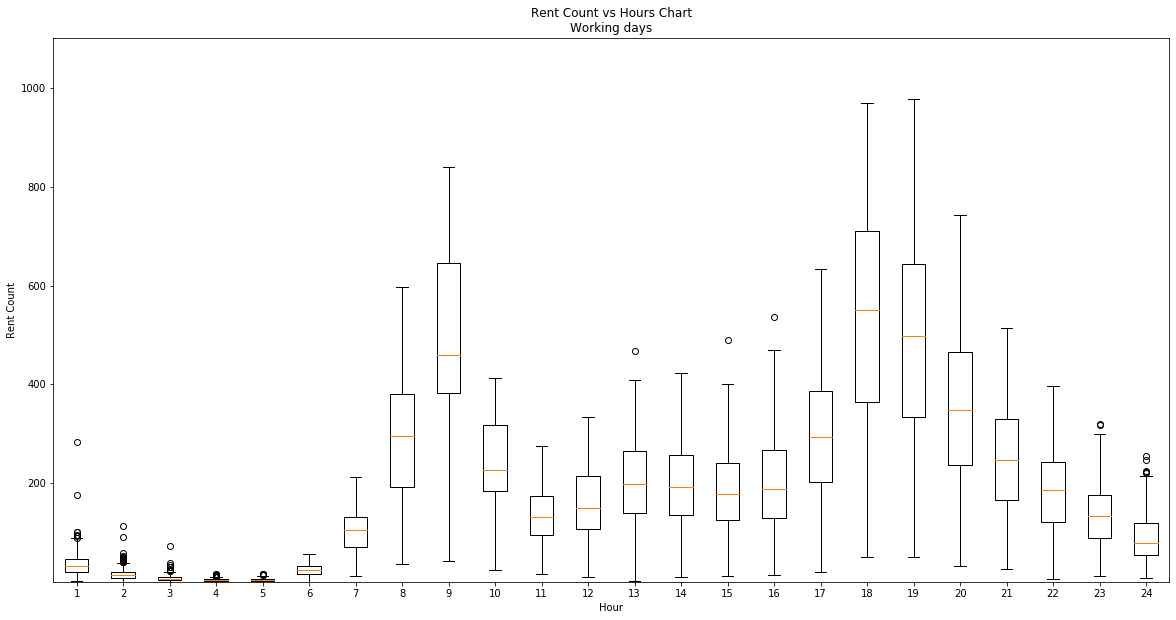

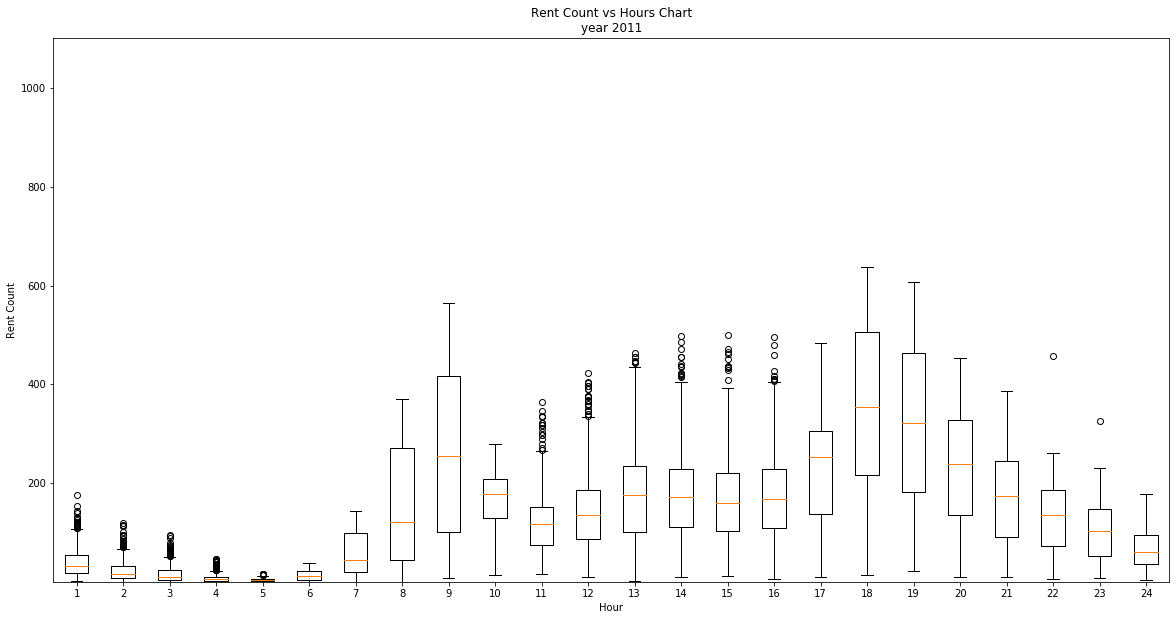

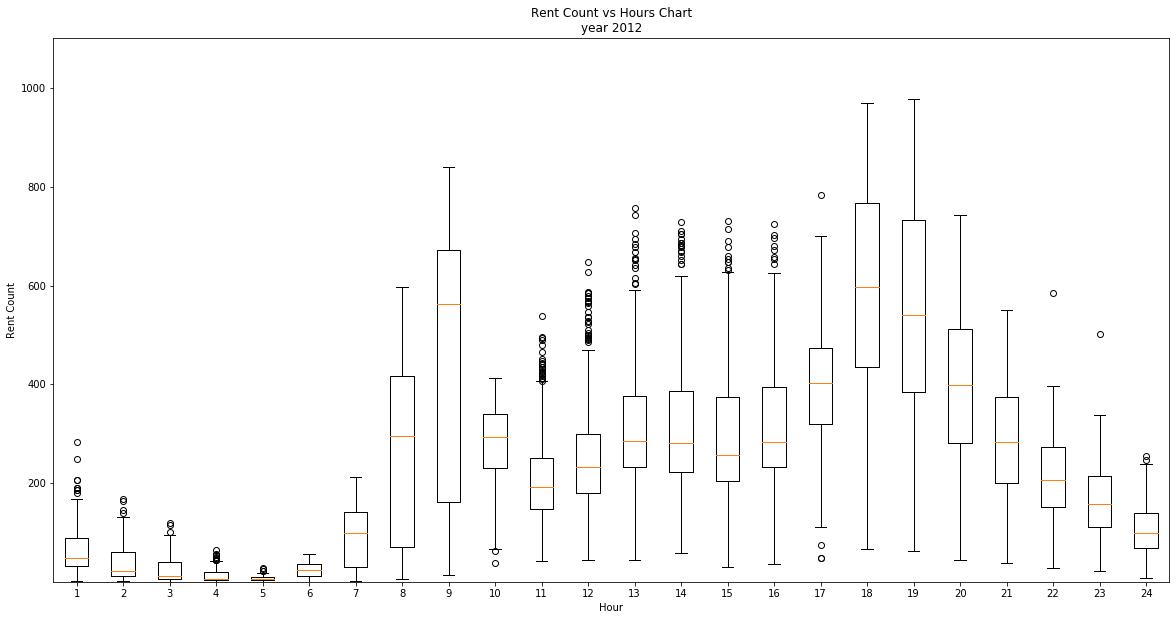

In [45]:
def plot_hours(data, message=''):
    plot_data = data.copy()
    plot_data['hour'] = data.datetime.dt.hour

    hours_count_dict = {}
    for hour in range(24):
        hours_count_dict[hour] = plot_data[plot_data.hour == hour]['count'].values

    plt.figure(figsize=(20, 10))
    plt.ylabel("Rent Count")
    plt.xlabel("Hour")
    plt.title("Rent Count vs Hours Chart\n" + message)
    plt.boxplot([hours_count_dict[hour] for hour in range(24)])

    axis = plt.gca()
    axis.set_ylim([1, 1100])


plot_hours(train[train.workingday == 0], 'Non Working Days')
plot_hours(train[train.workingday == 1], 'Working days')
plot_hours(train[train.datetime.dt.year == 2011], 'year 2011')
plot_hours(train[train.datetime.dt.year == 2012], 'year 2012')

In [50]:
import numpy as np
train = train[np.abs(train["count"] - train["count"].mean()) <= (3 * train["count"].std())]
train.shape


(10739, 12)


Metrics:
Root Mean Squared Logarithmic Error

\begin{align}
\sqrt{\frac{1}{n} 
\sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
\end{align}

  - **n** is the number of hours in the test set
  - **p** is your predicted count
  - **a** is the actual count

In [52]:
!pip install ml_metrics

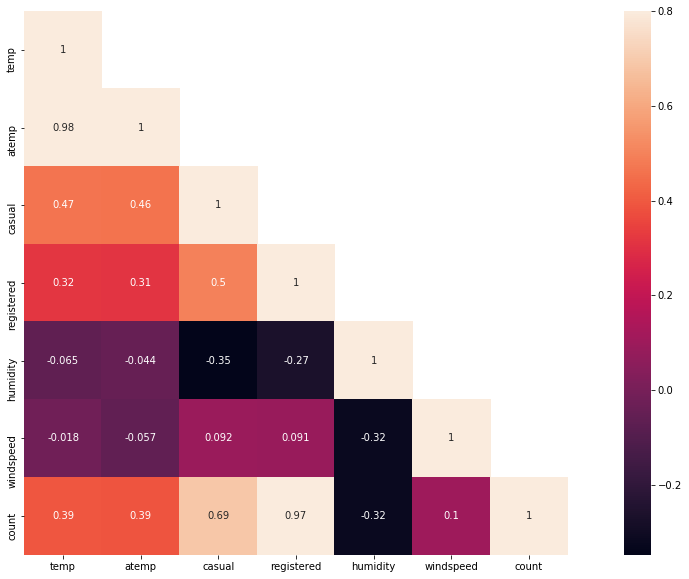

In [62]:
import calendar
import seaborn

from datetime import datetime
from ml_metrics import rmsle
from sklearn.model_selection import GroupKFold
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# correlation_matrix
correlation_matrix = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]].corr()
mask = np.array(correlation_matrix)
mask[np.tril_indices_from(mask)] = False
figure, axis= plt.subplots()
figure.set_size_inches(20, 10)
seaborn.heatmap(correlation_matrix, mask=mask, vmax=.8, square=True, annot=True)

# Feature engineering
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

In [64]:
features = train.select_dtypes(include=[np.int64, np.float64]).columns.values
black_list = ['count', 'casual', 'registered', 'windspeed', 'atemp']
features = [feature for feature in features if feature not in black_list]
features

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'humidity',
 'year',
 'month',
 'day',
 'hour']

In [153]:
# Dummy approach
X = train[features].values
y = train['count'].values
model = DummyRegressor(strategy='median')
model.fit(X, y)
y_prediction = model.predict(X)
rmsle(y, y_prediction)

1.4725894242962372

In [145]:
# General problem investigation with Decision Trees usage


def validation(df, features, n_folds=3):
    X = df[features].values
    y = df['count'].values
    groups = df['datetime'].dt.month.values
    group_kfold = GroupKFold(n_splits=n_folds)
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        yield X[train_idx], X[test_idx], y[train_idx], y[test_idx]

models, scores = [], []

for idx, (X_train, X_test, y_train, y_test) in enumerate(validation(train, features)):
    model = DecisionTreeRegressor(max_depth=10, random_state=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = rmsle(y_test, y_pred)
    
    models.append(model)
    scores.append(score)


np.mean(scores), np.std(scores)

(0.47413842017601704, 0.010550796863650014)

In [146]:
from sklearn.metrics import mean_squared_error
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [151]:
#from sklearn import tree
#tree.plot_tree(model, filled=True)

# Remove wind from feature blacklist
features.append('windspeed')

models, scores = [], []

for idx, (X_train, X_test, y_train, y_test) in enumerate(validation(train, features)):
    model = DecisionTreeRegressor(max_depth=10, random_state=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = rmsle(y_test, y_pred)
    
    models.append(model)
    scores.append(score)


np.mean(scores), np.std(scores)
# Smaler standard deviation

(0.4808517794039817, 0.0032304131136771646)

In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
model = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=1000)
model.fit(X, y)
# 10-Fold Cross validation
# validation_result = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_log_error')
validation_result = cross_validate(model, X_train, y_train, cv=10, scoring='neg_mean_squared_log_error', return_estimator =True)
# np.mean(validation_result), np.std(validation_result)
validation_result
np.mean(validation_result['test_score']), np.std(validation_result['test_score'])

(-0.23732331891485195, 0.1330615763741996)

In [167]:
Xt = test[features].values
y_pred = model.predict(Xt)
y_pred[y_pred<0] = 0
test['count'] = y_pred
test[ ['datetime', 'count'] ].to_csv('agg_rf.csv', index=False)
files.download('agg_rf.csv') 

MessageError: ignored

[00:34:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:35:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

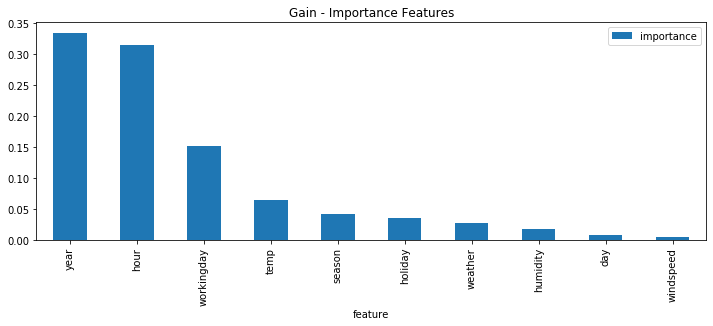

In [173]:
import xgboost as xgb
model = xgb.XGBRegressor(max_depth=10, n_estimators=500, random_state=2000)
validation_result = cross_val_score(model, X_train, y_train, cv=10)
model.fit(X, y)
np.mean(validation_result), np.std(validation_result)


def draw_importance_features(model, df, importance_type='gain'):

    fscore = model.get_booster().get_score(importance_type=importance_type) #cover, gain, weight
    maps_name = dict([ ("f{0}".format(i), col) for i, col in enumerate(df.columns)])

    impdf = pd.DataFrame([ {'feature': maps_name[k], 'importance': fscore[k]} for k in fscore ])
    impdf = impdf.sort_values(by='importance', ascending=False).reset_index(drop=True)
    impdf['importance'] /= impdf['importance'].sum()
    impdf.index = impdf['feature']

    impdf.plot(kind='bar', title='{0} - Importance Features'.format(importance_type.title()), figsize=(12, 4))
draw_importance_features(model, train[features], importance_type='gain')

0.799608596462978 0.11508231994827108
[00:50:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:l

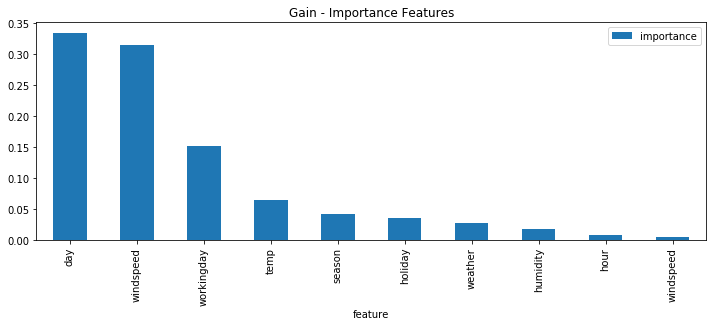

In [186]:
print(np.mean(validation_result), np.std(validation_result))
# dropFeatures = ["count","datetime", "year", "month"]
# train  = train.drop(dropFeatures,axis=1)
# test  = test.drop(dropFeatures,axis=1)
# features.remove("year")
# features.remove("count")
# features.remove("datetime")
# features.remove("month")
model = xgb.XGBRegressor(max_depth=10, n_estimators=500, random_state=2000)
validation_result = cross_val_score(model, X_train, y_train, cv=10)
model.fit(X, y)
print(np.mean(validation_result), np.std(validation_result))


def draw_importance_features(model, df, importance_type='gain'):

    fscore = model.get_booster().get_score(importance_type=importance_type) #cover, gain, weight
    maps_name = dict([ ("f{0}".format(i), col) for i, col in enumerate(df.columns)])

    impdf = pd.DataFrame([ {'feature': maps_name[k], 'importance': fscore[k]} for k in fscore ])
    impdf = impdf.sort_values(by='importance', ascending=False).reset_index(drop=True)
    impdf['importance'] /= impdf['importance'].sum()
    impdf.index = impdf['feature']

    impdf.plot(kind='bar', title='{0} - Importance Features'.format(importance_type.title()), figsize=(12, 4))
draw_importance_features(model, train[features], importance_type='gain')